In [147]:
" SGC model using torch geometric with Cora"
" Node2Vec model using torch geometric with Cora"
import torch
import torch.nn as nn
from torch_geometric.datasets import Planetoid # The citation network datasets “Cora”, “CiteSeer” and “PubMed” 
from torch_geometric.nn import SGConv # Import Node2Vec Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F

import os

In [148]:

" **************** IMPORT DATA ********************"
path = os.getcwd() # Directory to download dataset
dataset_name = "Cora"
dataset = Planetoid(path, dataset_name) # Download the dataset: “Cora”, “CiteSeer” and “PubMed” 
data = dataset[0] # Tensor representation of the Cora-Planetoid data
print(f'{dataset_name}: ', data)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

" **************** CONSTRUCT THE MODEL  ********************"
SGC_model = SGConv(in_channels= data.num_features, # Number of features
                   out_channels= dataset.num_classes, # Dimension of embedding
                   K = 1, cached =True)

" **************** GET EMBEDDING  ********************"
print(" Shape of the original data: ", data.x.shape)
print(" Shape of the embedding data: ", SGC_model(data.x,data.edge_index).shape)

" **************** CONSTRUCT THE MODEL FOR CLASSIFICATION  ********************"
class SGCNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(in_channels= data.num_features, # Number of features
                   out_channels= dataset.num_classes, # Dimension of embedding
                   K = 1, cached =True)

    def forward(self):

        x = self.conv1(data.x,  data.edge_index) #Applying convolution to data
        #nn.init.kaiming_uniform_(self.conv1.lin.weight, mode='fan_in')
        nn.init.xavier_normal_(self.conv1.lin.weight, gain=nn.init.calculate_gain('relu'))
        #nn.init.normal_(self.conv1.lin.weight)
        
        # computation of log softmax
        return F.log_softmax(x, dim=1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SGC_model, data = SGCNet().to(device), data.to(device)
optimizer = torch.optim.Adam(SGC_model.parameters(), lr=0.2, weight_decay=0.005)

# What are the learning parameters:
for i, parameter in SGC_model.named_parameters():
    print(" Parameter {}".format(i))
    print("Shape: ",parameter.shape)

" **************** TRAIN FUNCTION ********************"
def train():
    SGC_model.train() # Set the model.training to be True
    optimizer.zero_grad() # Reset the gradient
    predicted_y = SGC_model() # predicted y in log softmax prob
    true_y = data.y # True labels
    losses = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    losses.backward()
    optimizer.step() # Update the parameters such that is minimized the losses

" **************** TEST FUNCTION ********************"
def test():
    SGC_model.eval() # Set the model.training to be False
    logits = SGC_model() # Log prob of all data
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1] #Transforming log prob to actual labels
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

" **************** PUTTING IT ALL TOGETHER ********************"
all_test_acc = []
best_val_acc = test_acc = 0
for epoch in range(1, 101):
    train() 
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    all_test_acc.append(test_acc)
    print(log.format(epoch, train_acc, best_val_acc, test_acc))

Cora:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
 Shape of the original data:  torch.Size([2708, 1433])
 Shape of the embedding data:  torch.Size([2708, 7])
 Parameter conv1.lin.weight
Shape:  torch.Size([7, 1433])
 Parameter conv1.lin.bias
Shape:  torch.Size([7])
Epoch: 001, Train: 0.9714, Val: 0.5880, Test: 0.6160
Epoch: 002, Train: 0.9714, Val: 0.5880, Test: 0.6160
Epoch: 003, Train: 0.9714, Val: 0.5880, Test: 0.6160
Epoch: 004, Train: 0.9714, Val: 0.5880, Test: 0.6160
Epoch: 005, Train: 0.9786, Val: 0.5880, Test: 0.6160
Epoch: 006, Train: 0.9786, Val: 0.6420, Test: 0.6690
Epoch: 007, Train: 0.9643, Val: 0.6420, Test: 0.6690
Epoch: 008, Train: 0.9714, Val: 0.6420, Test: 0.6690
Epoch: 009, Train: 0.9571, Val: 0.6420, Test: 0.6690
Epoch: 010, Train: 0.9714, Val: 0.6420, Test: 0.6690
Epoch: 011, Train: 0.9643, Val: 0.6420, Test: 0.6690
Epoch: 012, Train: 0.9714, Val: 0.6420, Test: 0.6690
Epoch: 013, Train: 0.9714, Val: 0

In [145]:
#random_init = all_test_acc
#kaiming_init = all_test_acc
#xavier_init = all_test_acc
normalDist_init = all_test_acc

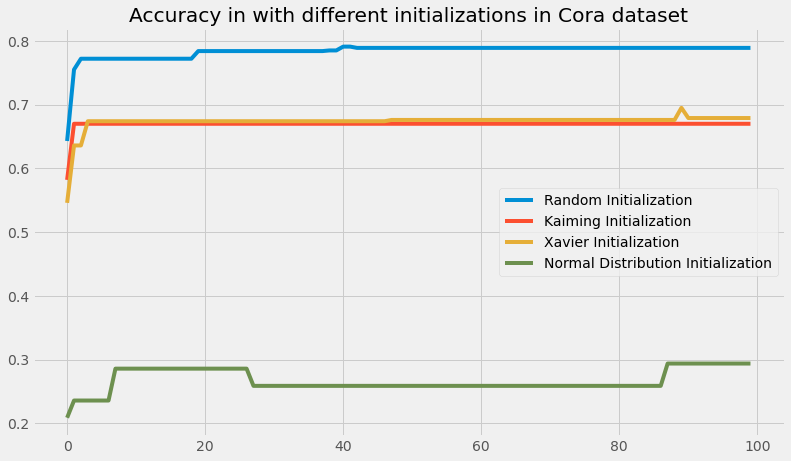

In [146]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12,7)
# plot lines
y = range(100)
plt.plot(y,random_init, label = "Random Initialization")
plt.plot(y,kaiming_init, label = "Kaiming Initialization")
plt.plot(y,xavier_init, label = "Xavier Initialization")
plt.plot(y,normalDist_init, label = "Normal Distribution Initialization")
plt.title(f'Accuracy in with different initializations in {dataset_name} dataset')
plt.legend()
plt.show()

In [149]:
w = torch.empty(3, 5)
nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))

tensor([[-0.3812,  1.0574,  1.0248,  0.1609,  0.7726],
        [-0.2078,  1.0609, -1.1770,  0.3134,  0.1009],
        [-1.1498,  0.4806, -1.0977, -0.0766,  0.4554]])

In [150]:
w = torch.empty(3, 5)
nn.init.kaiming_uniform_(w, mode='fan_in', nonlinearity='relu')

tensor([[ 0.8935, -0.6276, -0.1506, -0.3007,  0.1609],
        [ 0.0547, -0.6514,  0.0101, -0.3736, -1.0049],
        [ 0.5508, -0.5097,  0.7747,  0.6475,  0.5635]])